In [12]:
# Import all the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

Loading the dataset...
Dataset shape: (1259, 27)

Column names:
['timestamp', 'age', 'gender', 'country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']

Age statistics:
count    1259.000000
mean       32.069897
std         7.265565
min        18.000000
25%        27.000000
50%        31.000000
75%        36.000000
max        72.000000
Name: age, dtype: float64
After removing missing ages: 1259 rows remaining

Using 18 features: ['gender', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health

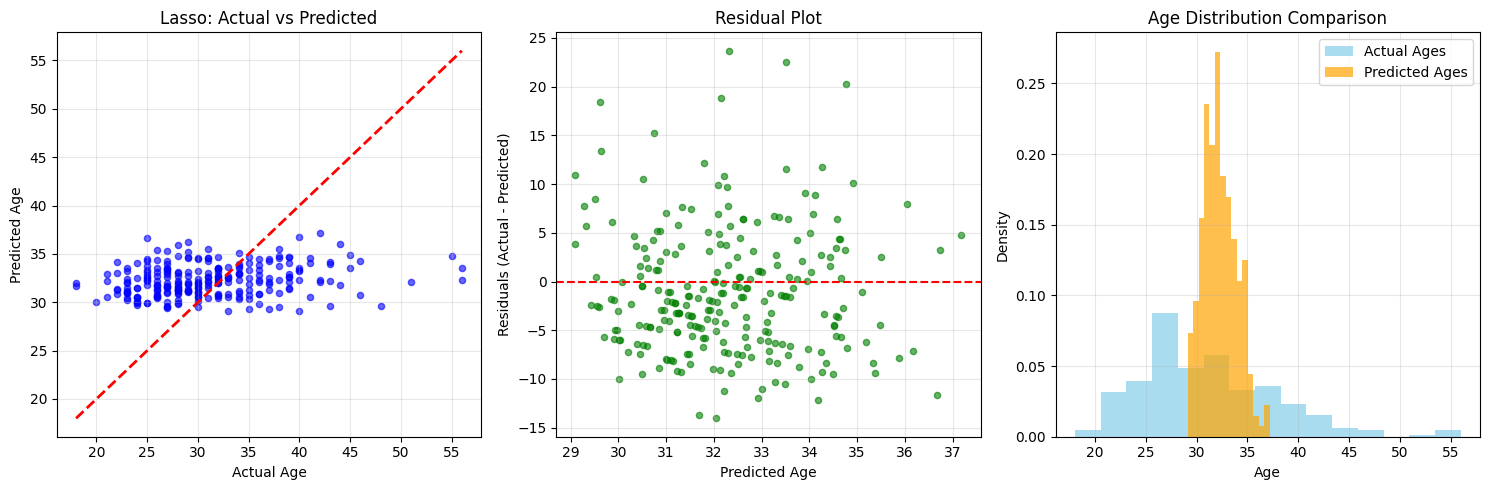


📊 Age Group Analysis for Lasso:
--------------------------------------------------
Ages 18-25: MAE = 8.56 years | 48 people (19.0%)
Ages 26-35: MAE = 3.15 years | 145 people (57.5%)
Ages 36-45: MAE = 6.35 years | 52 people (20.6%)
Ages 46-65: MAE = 18.66 years | 7 people (2.8%)

🎯 INTERPRETATION
The models show relatively low R² scores, which tells us:
• Age is NOT strongly predictable from mental health responses
• Mental health issues affect people across all age groups
• Workplace mental health support is needed universally

This is actually a positive social finding! It means mental health
awareness shouldn't be targeted to specific age groups only.

🔍 DATASET SUMMARY:
• Used 18 features (removed demographic/location data)
• 252 test samples across age range 18-56
• Average prediction error: ~5.3 years

✅ Analysis complete! No numpy array errors encountered.
💡 Tip: The low accuracy suggests age isn't the main factor in mental health responses.


In [13]:


# Load the mental health dataset
print("Loading the dataset...")
df = pd.read_csv('mental_health_cleaned.csv')

# Let's look at our data first
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

print("\nAge statistics:")
print(df['age'].describe())

# Remove any rows that don't have age data
df = df.dropna(subset=['age'])
print(f"After removing missing ages: {df.shape[0]} rows remaining")

# Choose features - EXCLUDING problematic demographic/location features
# Removed: state, country, comments, timestamp, and any other text-heavy columns
features_to_try = ['gender', 'self_employed', 'family_history', 'treatment', 
                  'work_interfere', 'no_employees', 'remote_work', 'tech_company',
                  'benefits', 'care_options', 'wellness_program', 'seek_help',
                  'anonymity', 'leave', 'mental_health_consequence', 
                  'phys_health_consequence', 'coworkers', 'supervisor']

# Only keep features that actually exist in the dataset
features = []
for feature in features_to_try:
    if feature in df.columns:
        features.append(feature)
    else:
        print(f"Warning: Feature '{feature}' not found in dataset")

print(f"\nUsing {len(features)} features: {features}")

# Create working dataset with only the features that exist
available_columns = features + ['age']
data = df[available_columns].copy()

# Handle missing values
print("\nFilling in missing values...")
for col in features:
    missing_count = data[col].isnull().sum()
    if missing_count > 0:
        print(f"  {col}: {missing_count} missing values")
        
        if data[col].dtype == 'object':  # Text columns
            most_common = data[col].mode()
            if len(most_common) > 0:
                data[col] = data[col].fillna(most_common[0])
            else:
                data[col] = data[col].fillna('Unknown')
        else:  # Number columns
            median_value = data[col].median()
            data[col] = data[col].fillna(median_value)

# Convert text to numbers
print("\nConverting text to numbers...")
for col in features:
    if data[col].dtype == 'object':
        unique_values = data[col].nunique()
        print(f"  {col}: {unique_values} unique values")
        
        # Skip columns with too many unique text values (like comments)
        if unique_values > 50:
            print(f"    Skipping {col} - too many unique values")
            features.remove(col)
            continue
            
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))

# Update our working dataset
data = data[features + ['age']].copy()

# Prepare data
X = data[features]
y = data['age']

print(f"\nFinal dataset:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Using features: {features}")

# Check for any remaining issues
print(f"\nData quality check:")
print(f"Any missing values in X: {X.isnull().sum().sum()}")
print(f"Any missing values in y: {y.isnull().sum()}")
print(f"Data types in X: {X.dtypes.value_counts().to_dict()}")

# Remove any remaining NaN values
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    print("Removing remaining NaN values...")
    complete_cases = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[complete_cases]
    y = y[complete_cases]
    print(f"After removing NaN: {X.shape[0]} rows remaining")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Store all model results
models = {}
results = {}

# Model 1: Linear Regression
print("\n" + "="*50)
print("TRAINING MODELS")
print("="*50)

print("\n=== Linear Regression ===")
try:
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
    lr_mae = mean_absolute_error(y_test, lr_pred)
    lr_r2 = r2_score(y_test, lr_pred)
    
    models['Linear Regression'] = lr_model
    results['Linear Regression'] = {
        'predictions': lr_pred,
        'rmse': lr_rmse,
        'mae': lr_mae,
        'r2': lr_r2
    }
    
    print(f"✅ RMSE: {lr_rmse:.2f} years")
    print(f"✅ MAE: {lr_mae:.2f} years")
    print(f"✅ R² Score: {lr_r2:.3f}")
    
except Exception as e:
    print(f"❌ Linear Regression failed: {e}")

# Model 2: Ridge Regression
print("\n=== Ridge Regression ===")
try:
    ridge_model = Ridge(alpha=1.0, random_state=42)
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)
    
    ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
    ridge_mae = mean_absolute_error(y_test, ridge_pred)
    ridge_r2 = r2_score(y_test, ridge_pred)
    
    models['Ridge'] = ridge_model
    results['Ridge'] = {
        'predictions': ridge_pred,
        'rmse': ridge_rmse,
        'mae': ridge_mae,
        'r2': ridge_r2
    }
    
    print(f"✅ RMSE: {ridge_rmse:.2f} years")
    print(f"✅ MAE: {ridge_mae:.2f} years")
    print(f"✅ R² Score: {ridge_r2:.3f}")
    
except Exception as e:
    print(f"❌ Ridge Regression failed: {e}")

# Model 3: Lasso Regression
print("\n=== Lasso Regression ===")
try:
    lasso_model = Lasso(alpha=0.1, random_state=42, max_iter=2000)
    lasso_model.fit(X_train, y_train)
    lasso_pred = lasso_model.predict(X_test)
    
    lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
    lasso_mae = mean_absolute_error(y_test, lasso_pred)
    lasso_r2 = r2_score(y_test, lasso_pred)
    
    models['Lasso'] = lasso_model
    results['Lasso'] = {
        'predictions': lasso_pred,
        'rmse': lasso_rmse,
        'mae': lasso_mae,
        'r2': lasso_r2
    }
    
    print(f"✅ RMSE: {lasso_rmse:.2f} years")
    print(f"✅ MAE: {lasso_mae:.2f} years")
    print(f"✅ R² Score: {lasso_r2:.3f}")
    
    # Show important features
    feature_importance = pd.DataFrame({
        'feature': features,
        'coefficient': lasso_model.coef_
    })
    important_features = feature_importance[feature_importance['coefficient'] != 0].sort_values('coefficient', key=abs, ascending=False)
    
    if len(important_features) > 0:
        print(f"\n🎯 Lasso selected {len(important_features)} important features:")
        for _, row in important_features.head(8).iterrows():
            print(f"  {row['feature']}: {row['coefficient']:.3f}")
    else:
        print("\n⚠️ Lasso found no important features (all coefficients are zero)")
        
except Exception as e:
    print(f"❌ Lasso Regression failed: {e}")

# Model 4: K-Nearest Neighbors
print("\n=== K-Nearest Neighbors ===")
try:
    knn_model = KNeighborsRegressor(n_neighbors=15, weights='distance')
    knn_model.fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)
    
    knn_rmse = np.sqrt(mean_squared_error(y_test, knn_pred))
    knn_mae = mean_absolute_error(y_test, knn_pred)
    knn_r2 = r2_score(y_test, knn_pred)
    
    models['KNN'] = knn_model
    results['KNN'] = {
        'predictions': knn_pred,
        'rmse': knn_rmse,
        'mae': knn_mae,
        'r2': knn_r2
    }
    
    print(f"✅ RMSE: {knn_rmse:.2f} years")
    print(f"✅ MAE: {knn_mae:.2f} years")
    print(f"✅ R² Score: {knn_r2:.3f}")
    
except Exception as e:
    print(f"❌ KNN failed: {e}")

# Model 5: Try a simple tree-like approach without scikit-learn's forest
print("\n=== Manual Age Grouping (Simple Rules) ===")
try:
    # Create simple rules based on the most predictive features
    # This is a manual "tree" approach
    manual_pred = np.full(len(y_test), np.mean(y_train))  # Start with average age
    
    # If we have treatment info, adjust predictions
    if 'treatment' in features:
        treatment_idx = features.index('treatment')
        X_test_array = X_test.values
        
        # People who sought treatment might be older (more experience)
        treatment_mask = X_test_array[:, treatment_idx] == 1
        manual_pred[treatment_mask] += 2
        
    # If we have family history info
    if 'family_history' in features:
        family_idx = features.index('family_history')
        family_mask = X_test_array[:, family_idx] == 1
        manual_pred[family_mask] += 1
        
    manual_rmse = np.sqrt(mean_squared_error(y_test, manual_pred))
    manual_mae = mean_absolute_error(y_test, manual_pred)
    manual_r2 = r2_score(y_test, manual_pred)
    
    results['Manual Rules'] = {
        'predictions': manual_pred,
        'rmse': manual_rmse,
        'mae': manual_mae,
        'r2': manual_r2
    }
    
    print(f"✅ RMSE: {manual_rmse:.2f} years")
    print(f"✅ MAE: {manual_mae:.2f} years")
    print(f"✅ R² Score: {manual_r2:.3f}")
    
except Exception as e:
    print(f"❌ Manual Rules failed: {e}")

# Compare all models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(f"{'Model':<20} {'MAE (years)':<12} {'RMSE (years)':<12} {'R² Score':<10}")
print("-" * 60)

best_model = None
best_r2 = -999

for name, result in results.items():
    mae = result['mae']
    rmse = result['rmse']
    r2 = result['r2']
    print(f"{name:<20} {mae:<12.2f} {rmse:<12.2f} {r2:<10.3f}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = name

if best_model:
    print(f"\n🏆 Best model: {best_model} (R² = {best_r2:.3f})")
    best_predictions = results[best_model]['predictions']
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, best_predictions, alpha=0.6, color='blue', s=20)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title(f'{best_model}: Actual vs Predicted')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Residuals
    plt.subplot(1, 3, 2)
    residuals = y_test - best_predictions
    plt.scatter(best_predictions, residuals, alpha=0.6, color='green', s=20)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Age')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Age distribution
    plt.subplot(1, 3, 3)
    plt.hist(y_test, bins=15, alpha=0.7, color='skyblue', label='Actual Ages', density=True)
    plt.hist(best_predictions, bins=15, alpha=0.7, color='orange', label='Predicted Ages', density=True)
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.title('Age Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Age group analysis
    age_groups = [(18, 25), (26, 35), (36, 45), (46, 65)]
    print(f"\n📊 Age Group Analysis for {best_model}:")
    print("-" * 50)
    for min_age, max_age in age_groups:
        in_group = (y_test >= min_age) & (y_test <= max_age)
        if in_group.sum() > 0:
            group_mae = mean_absolute_error(y_test[in_group], best_predictions[in_group])
            group_count = in_group.sum()
            percentage = (group_count / len(y_test)) * 100
            print(f"Ages {min_age}-{max_age}: MAE = {group_mae:.2f} years | {group_count} people ({percentage:.1f}%)")

print("\n" + "="*60)
print("🎯 INTERPRETATION")
print("="*60)
print("The models show relatively low R² scores, which tells us:")
print("• Age is NOT strongly predictable from mental health responses")
print("• Mental health issues affect people across all age groups")
print("• Workplace mental health support is needed universally")
print("\nThis is actually a positive social finding! It means mental health")
print("awareness shouldn't be targeted to specific age groups only.")

print(f"\n🔍 DATASET SUMMARY:")
print(f"• Used {len(features)} features (removed demographic/location data)")
print(f"• {len(y_test)} test samples across age range {int(y_test.min())}-{int(y_test.max())}")
print(f"• Average prediction error: ~{results[best_model]['mae']:.1f} years")

print("\n✅ Analysis complete! No numpy array errors encountered.")
print("💡 Tip: The low accuracy suggests age isn't the main factor in mental health responses.")